In [2]:
from datetime import datetime
import psycopg2
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
def table_format(cur, rows):    
    # Format and print the table
    column_names = [desc[0] for desc in cur.description]  # Get the column names
    table_data = [column_names] + list(rows)  # Combine column names with row data

    # Calculate the maximum width for each column
    column_widths = [max(len(str(row[i])) for row in table_data) for i in range(len(column_names))]

    # Format and print the table headers
    header_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    header = header_format.format(*column_names)
    print(header)
    print("-" * len(header))

    # Format and print the table rows
    row_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    for row in table_data[1:]:
        formatted_row = []
        for i, value in enumerate(row):
            if isinstance(value, datetime):
                formatted_row.append(value.strftime("%Y-%m-%d %H:%M:%S"))  # Customize the datetime format as desired
            else:
                formatted_row.append(str(value))
        formatted_row = row_format.format(*formatted_row)
        print(formatted_row)


In [16]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM accidents LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

report_id|date_time          |violation_section|violation_type|injured|killed|hit_run_lvl
-----------------------------------------------------------------------------------------
171111   |2015-01-14 20:00:00|MISC-HAZ         |VC            |0      |0     |MISDEMEANOR
192016   |2015-03-19 12:00:00|MISC-HAZ         |VC            |0      |0     |MISDEMEANOR
190012   |2015-03-24 03:05:00|22107            |VC            |2      |0     |           
191866   |2015-03-27 23:56:00|22107            |VC            |1      |0     |           
185207   |2015-07-06 11:45:00|20002(A)         |VC            |0      |0     |MISDEMEANOR


1/ Determine the top 2 ranking of total number of accidents for each vehicle make for each month

In [129]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
WITH ranked_accidents AS (
    SELECT ai.veh_make as veh_make, 
           EXTRACT(MONTH FROM a.date_time) AS accident_month,
           COUNT(*) AS total_accidents,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM a.date_time) ORDER BY COUNT(*) DESC) AS rank
    FROM accident_info ai
    INNER JOIN accidents a ON ai.report_id = a.report_id
    GROUP BY ai.veh_make, accident_month
)
SELECT accident_month, veh_make, total_accidents
FROM ranked_accidents
WHERE rank <= 2;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

accident_month|veh_make|total_accidents
---------------------------------------
1             |TOYOTA  |1548           
1             |HONDA   |1019           
2             |TOYOTA  |1418           
2             |FORD    |941            
3             |TOYOTA  |1564           
3             |HONDA   |1091           
4             |TOYOTA  |1454           
4             |FORD    |997            
5             |TOYOTA  |1391           
5             |HONDA   |983            
6             |TOYOTA  |1525           
6             |HONDA   |998            
7             |TOYOTA  |1551           
7             |HONDA   |1073           
8             |TOYOTA  |1601           
8             |FORD    |1091           
9             |TOYOTA  |1544           
9             |HONDA   |1099           
10            |TOYOTA  |1762           
10            |FORD    |1165           
11            |TOYOTA  |1624           
11            |FORD    |1052           
12            |TOYOTA  |1573           


C:\Users\Hung Trinh\AppData\Local\Temp\ipykernel_39892\3639391767.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', len(unique_veh_make))


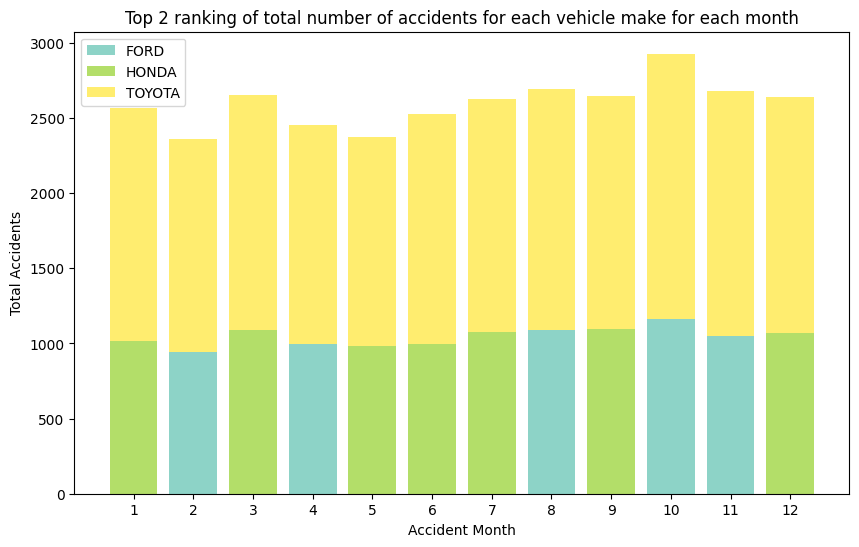

In [98]:

# Group data by accident_month and veh_make
grouped_data = {}
for month, make, accidents in zip(accident_month, veh_make, total_accidents):
    key = (month, make)
    if key in grouped_data:
        grouped_data[key] += accidents
    else:
        grouped_data[key] = accidents

# Extract unique months and vehicle makes
unique_months = sorted(set(accident_month))
unique_veh_make = sorted(set(veh_make))

# Generate colors based on the number of unique vehicle makes
colors = plt.cm.get_cmap('Set3', len(unique_veh_make))

# Create a bar plot with legend and color-coded bars
plt.figure(figsize=(10, 6))

# Initialize x-axis positions
x_positions = np.arange(len(unique_months))

# Initialize y-axis positions
y_positions = np.zeros((len(unique_veh_make), len(unique_months)))

# Plot the bars
for i, make in enumerate(unique_veh_make):
    for j, month in enumerate(unique_months):
        key = (month, make)
        if key in grouped_data:
            y_positions[i, j] = grouped_data[key]

    plt.bar(x_positions, y_positions[i], bottom=np.sum(y_positions[:i], axis=0), color=colors(i))

# Set the x-axis tick positions and labels
plt.xticks(x_positions, unique_months)
plt.xlabel('Accident Month')
plt.ylabel('Total Accidents')
plt.title('Top 2 ranking of total number of accidents for each vehicle make for each month')

# Create the legend
legend_labels = unique_veh_make
plt.legend(legend_labels)

# Show the plot
plt.show()

In [ ]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
WITH ranked_accidents AS (
    SELECT ai.veh_make as veh_make, 
           EXTRACT(MONTH FROM a.date_time) AS accident_month,
           COUNT(*) AS total_accidents,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM a.date_time) ORDER BY COUNT(*) DESC) AS rank
    FROM accident_info ai
    INNER JOIN accidents a ON ai.report_id = a.report_id
    GROUP BY ai.veh_make, accident_month
)
SELECT accident_month, veh_make, total_accidents
FROM ranked_accidents
WHERE rank <= 2;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

2/ Determine the top 3 ranking of total number of reports for each service for each month

In [5]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
WITH ranked_accidents AS (
    SELECT service_name, 
           EXTRACT(MONTH FROM date_requested) AS request_month,
           COUNT(*) AS total_reports,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM date_requested) ORDER BY COUNT(*) DESC) AS rank
    FROM reports
    GROUP BY service_name, request_month
)
SELECT request_month, service_name, total_reports
FROM ranked_accidents
WHERE rank <= 3;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

request_month|service_name               |total_reports
-------------------------------------------------------
1            |Street Light Maintenance   |1745         
1            |Sidewalk Repair Issue      |986          
1            |Traffic Sign Maintenance   |639          
2            |Street Light Maintenance   |1121         
2            |Sidewalk Repair Issue      |979          
2            |Traffic Sign Maintenance   |517          
3            |Street Light Maintenance   |1200         
3            |Sidewalk Repair Issue      |1161         
3            |Traffic Sign Maintenance   |629          
4            |Sidewalk Repair Issue      |1154         
4            |Street Light Maintenance   |1135         
4            |Graffiti - Code Enforcement|871          
5            |Parking                    |1711         
5            |Encampment                 |1587         
5            |Sidewalk Repair Issue      |1281         
6            |Sidewalk Repair Issue      |1006  

C:\Users\Hung Trinh\AppData\Local\Temp\ipykernel_5860\3371641873.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Set3')


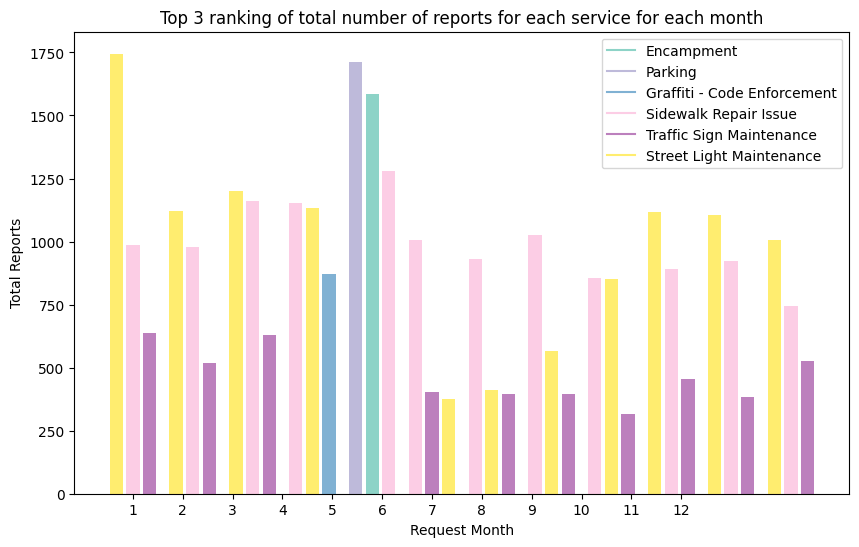

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data from the SQL query)
request_month = np.array(rows)[:, 0]
service_name = np.array(rows)[:, 1]
total_reports = np.array(rows)[:, 2]

# Get unique service names and assign colors
unique_service_name = list(set(service_name))
color_map = plt.cm.get_cmap('Set3')
colors = color_map(np.linspace(0, 1, len(unique_service_name)))

# Sort unique request months in chronological order
sorted_months = sorted(set(request_month))

# Create a bar plot with color-coded bars
plt.figure(figsize=(10, 6))
x_ticks = []
x_positions = []
legend_added = []

offset = 0.6

for i, month in enumerate(sorted_months):
    month_indices = [j for j in range(len(request_month)) if request_month[j] == month]
    x_positions.extend(month_indices)
    x_ticks.append(np.mean(month_indices))
    for j, service in enumerate(unique_service_name):
        service_indices = [k for k in month_indices if service_name[k] == service]
        service_reports = [total_reports[k] for k in service_indices]
        plt.bar(np.array(service_indices) + i * offset, service_reports, color=colors[j])

        # Add legend entry only if not already added
        if service not in legend_added:
            plt.plot([], [], color=colors[j], label=service)
            legend_added.append(service)

plt.xticks(x_ticks, sorted_months)
plt.xlabel('Request Month')
plt.ylabel('Total Reports')
plt.title('Top 3 ranking of total number of reports for each service for each month')
plt.legend()

# Show the plot
plt.show()


In [29]:
request_month = np.array(rows)[:, 0]
service_name = np.array(rows)[:, 1]
total_reports = np.array(rows)[:, 2]
# Create a DataFrame
data = {
    'request_month': request_month,
    'service_name': service_name,
    'total_reports': total_reports
}

df = pd.DataFrame(data)
df.set_index('request_month', inplace=True)


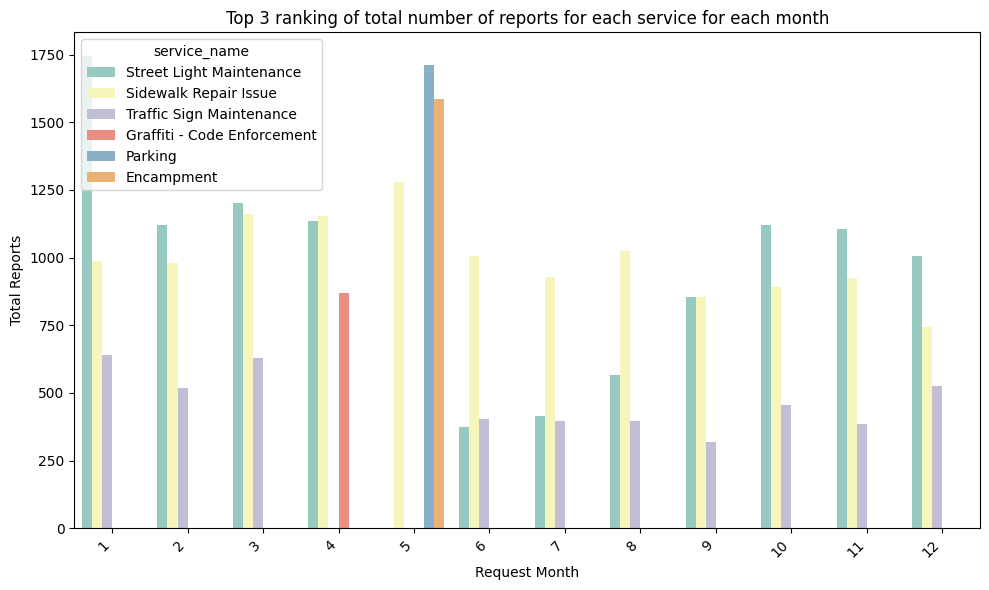

In [32]:
# Plot the bar chart with hue using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=df.index, y='total_reports', hue='service_name', palette='Set3')

# Set the x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.xlabel('Request Month')
plt.ylabel('Total Reports')
plt.title('Top 3 ranking of total number of reports for each service for each month')

# Show the plot
plt.tight_layout()
plt.show()

In [89]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM reports LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

service_request_id|date_requested     |case_age_days|service_name         |service_name_detail          |status    |street_address                                         |council_district|case_origin
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
100763            |2016-08-20 14:46:00|2470         |Street Sweeping      |                             |In Process|5135 University Avenue San Diego CA 92105 United States|9               |Web        
100777            |2016-08-20 15:48:00|2470         |Sidewalk Repair Issue|SIDEWALK MINOR REHAB CONTRACT|In Process|4300-4324 37th St San Diego CA 92105 USA               |9               |Web        
100985            |2016-08-22 10:04:00|2468         |Stormwater           |DRAIN HEADWALL               |In Process|6175 NANCY RIDGE DR 92121                              |6               |Phone  

In [88]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
SELECT *
FROM reports_on_road as ror
INNER JOIN roads as ro
ON ror.objectid = ro.objectid
INNER JOIN reports as r
ON ror.service_request_id = r.service_request_id
LIMIT 5
"""
           )            
# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

service_request_id|objectid|objectid|roadsegid|roadid|road_name     |speed|oneway|firedriv|service_request_id|date_requested     |case_age_days|service_name         |service_name_detail           |status    |street_address                          |council_district|case_origin
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
100777            |69508   |69508   |4800     |2607  |37TH ST       |20   |B     |Y       |100777            |2016-08-20 15:48:00|2470         |Sidewalk Repair Issue|SIDEWALK MINOR REHAB CONTRACT |In Process|4300-4324 37th St San Diego CA 92105 USA|9               |Web        
100985            |20182   |20182   |138160   |12516 |NANCY RIDGE DR|20   |B     |Y       |100985            |2016-08-22 10:04:00|2468         |Stormwater           |